In [ ]:
import pandas as pd
repo = "https://raw.githubusercontent.com/rcamwm/DATA301-project-data/main/"

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## GDP Dataset

### Description
The data shows the change in GDP from 1964 to 2021. We also had to clean the new data set with a larger time frame.

In [ ]:
# Import GDP dataset and condense into new DataFrame
df_gdp = pd.read_csv(
    repo + "/GDP-Values-Worldwide.csv", 
).drop(
    ['Country Code'], 
    axis=1
).set_index("Country Name").transpose()

df_gdp.index.set_names("Date", inplace=True)
df_gdp.index = pd.to_datetime(df_gdp.index).year
df_gdp.head()

Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
1960,NaN,2.129059e+10,537777811.1,1.040414e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.392050e+12,NaN,NaN,NaN,8.748597e+09,713000000.0,1.052990e+09
1961,NaN,2.180847e+10,548888895.6,1.112789e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.448390e+12,NaN,NaN,NaN,9.225996e+09,696285714.3,1.096647e+09
1962,NaN,2.370702e+10,546666677.8,1.194319e+10,NaN,NaN,NaN,NaN,NaN,2.445060e+10,...,NaN,NaN,NaN,1.550300e+12,NaN,NaN,NaN,9.813996e+09,693142857.1,1.117602e+09
1963,NaN,2.821004e+10,751111191.1,1.267633e+10,NaN,NaN,NaN,NaN,NaN,1.827212e+10,...,NaN,NaN,NaN,1.671350e+12,NaN,NaN,NaN,1.085420e+10,718714285.7,1.159512e+09
1964,NaN,2.611879e+10,800000044.4,1.383837e+10,NaN,NaN,NaN,NaN,NaN,2.560525e+10,...,NaN,NaN,NaN,1.830000e+12,NaN,NaN,NaN,1.195600e+10,839428571.4,1.217138e+09


## Historic NASDAQ Dataset

### Description
The data shows the change in the NASDAQ's price from 1971 to roughly the present. We also had to clean the new data set with a larger time frame.

In [ ]:
# Import NASDAQ dataset and set index to data
df_nasdaq = pd.read_csv(
    "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=NASDAQCOM&scale=left&cosd=1971-02-05&coed=2022-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%20Close&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-12-04&revision_date=2022-12-04&nd=1971-02-05", 
    parse_dates=True
).dropna()
df_nasdaq.columns = ["Date", "NASDAQ Closing Price"]
df_nasdaq.set_index("Date", inplace=True)
df_nasdaq = df_nasdaq.loc[df_nasdaq["NASDAQ Closing Price"] != "."]
df_nasdaq.head()

,NASDAQ Closing Price
Date,
1971-02-05,100.00
1971-02-08,100.84
1971-02-09,100.76
1971-02-10,100.69
1971-02-11,101.45


In [ ]:
def get_year_first_nasdaq(year):
  filtered = df_nasdaq[
      (df_nasdaq.index >= str(year)) & (df_nasdaq.index < str(year + 1))
  ]
  return float(filtered.iloc[0].values[0])

In [ ]:
nasdaq_dates = pd.DatetimeIndex(df_nasdaq.index)
df_nasdaq_yearly = pd.DataFrame(
    index=range(nasdaq_dates[0].year, nasdaq_dates[-1].year + 1),
    columns=["Beginning of Year NASDAQ Price"],
    dtype="float64"
)
df_nasdaq_yearly["Beginning of Year NASDAQ Price"] = df_nasdaq_yearly.apply(
    lambda year: get_year_first_nasdaq(year.name),
    axis=1
)
df_nasdaq_yearly.head()

,Beginning of Year NASDAQ Price
1971,100.00
1972,113.65
1973,134.63
1974,92.53
1975,60.70


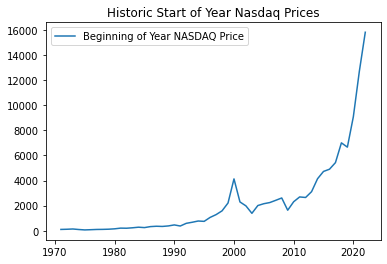

In [ ]:
df_nasdaq_yearly.plot(
    kind="line",
    title="Historic Start of Year Nasdaq Prices"
)

# NASDAQ Prediction Model

## Finding the countries whose GDP best predicts the NASDAQ.

In [ ]:
from itertools import combinations

# Returns a list of all possible combinations of a list of features
def get_list_combinations(feature_list, r="All"):
    feature_count = len(feature_list) if r == "All" else r
    list_combinations = []
    for n in range(feature_count + 1):
        list_combinations += list(combinations(feature_list, n))
    return list_combinations

In [ ]:
def get_cv_average_error(features, prediction):
    pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    cv_errs = -cross_val_score(
        pipeline, 
        X=features,
        y=prediction,
        scoring="neg_mean_squared_error", 
        cv=len(features)
    )
    return cv_errs.mean()


In [ ]:
df_gdp_stocks = pd.merge(df_gdp, df_nasdaq_yearly, left_index=True, right_index=True)
df_gdp_stocks.head()

,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe,Beginning of Year NASDAQ Price
1971,NaN,4.947892e+10,1.831109e+09,2.083282e+10,NaN,NaN,8.940982e+07,4.984169e+10,NaN,3.329320e+10,...,NaN,NaN,3.310260e+12,NaN,NaN,NaN,2.341108e+10,1.687000e+09,2.178716e+09,100.00
1972,NaN,5.351484e+10,1.595555e+09,2.526495e+10,NaN,NaN,1.134082e+08,5.938154e+10,NaN,3.473300e+10,...,NaN,NaN,3.816540e+12,NaN,NaN,NaN,2.451591e+10,1.910714e+09,2.677729e+09,113.65
1973,NaN,6.960079e+10,1.733333e+09,3.127382e+10,NaN,NaN,1.508201e+08,7.533011e+10,NaN,5.254400e+10,...,NaN,NaN,4.656240e+12,NaN,NaN,NaN,3.326277e+10,2.268714e+09,3.309354e+09,134.63
1974,NaN,8.605778e+10,2.155555e+09,4.421448e+10,NaN,NaN,1.865587e+08,1.428160e+11,NaN,7.243678e+10,...,NaN,NaN,5.366740e+12,NaN,NaN,NaN,4.138919e+10,3.121833e+09,3.982161e+09,92.53
1975,NaN,9.164915e+10,2.366667e+09,5.144473e+10,NaN,NaN,2.201272e+08,1.579100e+11,1.472067e+10,5.243865e+10,...,NaN,NaN,5.977990e+12,NaN,NaN,NaN,4.290692e+10,2.618667e+09,4.371301e+09,60.70


List of ten highest GDP countries according to https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal).

Ideally, we would have preferred to use all countries with available data to truly find the best results. But this was too computationally intensive, so we've limited the number of countries we'll be looking at.

In [ ]:
top_10_gdps = [
    "United States",
    "China",
    "Japan",
    "Germany",
    "India",
    "United Kingdom",
    "France",
    "Canada",
    "Russian Federation",
    "Italy"
]

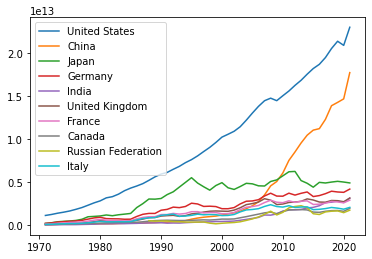

In [ ]:
df_gdp_stocks[top_10_gdps].plot(
    kind="line"
)

In [ ]:
gdp_country_errors = pd.Series(
    dtype='float64'
)
# Combinations limited to reduce computational time
country_groups = get_list_combinations(top_10_gdps, 3)
for country_group in country_groups[1:]:
  country_group_list = list(country_group)
  nan_filtered = df_gdp_stocks[
      country_group_list + ["Beginning of Year NASDAQ Price"]
  ].dropna()
  if not nan_filtered.empty:
    gdp_country_errors[str(country_group_list)] = get_cv_average_error(
        nan_filtered[country_group_list],
        nan_filtered["Beginning of Year NASDAQ Price"]
    )

In [ ]:
best_country_features = gdp_country_errors.loc[
    gdp_country_errors == gdp_country_errors.min()
].index[0].strip("[']").split("', '")

best_country_features

['United States', 'China', 'Canada']

## Finding the best k-value for k-nearest neighbors in predicting NASDAQ price based on GDP

In [ ]:
def get_cv_error_for_k(features, prediction, k):
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=k)
    )
    cv_errs = -cross_val_score(
        pipeline, 
        X=features,
        y=prediction,
        scoring="neg_mean_squared_error", 
        cv=len(features)
    )
    return cv_errs.mean()

In [ ]:
def get_best_k(features, prediction, max_k):
    k_errors = pd.Series(dtype='float64')
    for k in range(2, max_k): 
        k_errors[str(k)] = get_cv_error_for_k(
            features,
            prediction,
            k
        )
    return int(k_errors.loc[
        k_errors == k_errors.min()
    ].index.values[0]), k_errors

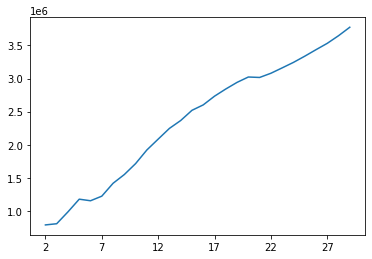

In [ ]:
best_fit_countries = df_gdp_stocks[
    best_country_features + ["Beginning of Year NASDAQ Price"]
].dropna()

k_return = get_best_k(
    best_fit_countries[best_country_features],
    best_fit_countries["Beginning of Year NASDAQ Price"],
    30
)

k_return[1].plot(kind="line")

In [ ]:
best_k = k_return[0]
best_k

2

## Create Stacked Model

In [ ]:
def get_stacking_model(X, y, k):
    linear_model = LinearRegression()
    linear_model.fit(X=X, y=y)

    knn_model = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=k)
    )
    knn_model.fit(X=X, y=y)

    stacking_model = StackingRegressor([
        ("linear", linear_model), 
        ("knn", knn_model)],
        final_estimator=LinearRegression()
    )
    stacking_model.fit(X=X, y=y)
    return stacking_model

In [ ]:
nasdaq_model = get_stacking_model(
    best_fit_countries[best_country_features],
    best_fit_countries["Beginning of Year NASDAQ Price"],
    best_k
)

## Model test

In [ ]:
def get_prediction_for_year(year):
  if year in best_fit_countries.index:
    return nasdaq_model.predict(pd.DataFrame(best_fit_countries[best_country_features].loc[year]).transpose())
  else:
    return float("nan")

In [ ]:
df_comparison = df_nasdaq_yearly
df_comparison = pd.merge( # Remove NaN rows
    best_fit_countries[[]], df_comparison, left_index=True, right_index=True
)
df_comparison["Predicted NASDAQ Price"] = nasdaq_model.predict(
    best_fit_countries[best_country_features]
)

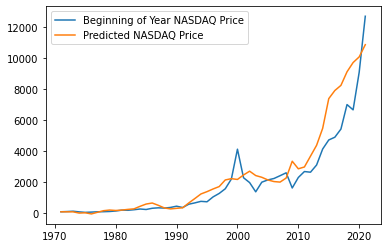

In [ ]:
df_comparison.plot(kind="line")

# Ethereum Prediction Model Based on NASDAQ

## Recent NASDAQ and Ethereum datasets

In [ ]:
# Import Ethereum dataset and set index to data
df_ethereum = pd.read_csv(
    repo + "ETH-USD-2.csv",
    index_col="Date", 
    parse_dates=True
)

# Condense data into new DataFrame
df_ethereum_clean = df_ethereum[["Close"]].rename(
    columns={"Close":"Close ETH"}
)
df_ethereum_clean.head()

,Close ETH
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [ ]:
# Import NASDAQ dataset and set index to data
df_nasdaq_recent = pd.read_csv(repo + "NASDAQ.csv",
    index_col="Date", 
    parse_dates=True
)

# Condense data into new DataFrame
df_nasdaq_clean = df_nasdaq_recent[["Close/Last"]].rename(
    columns={"Close/Last":"Close NASDAQ"}
)
df_nasdaq_clean.head()

,Close NASDAQ
Date,
2022-11-11,11323.33
2022-11-10,11114.15
2022-11-09,10353.17
2022-11-08,10616.20
2022-11-07,10564.52


In [ ]:
df_stocks_crypto = df_nasdaq_clean.join(
    df_ethereum_clean
).dropna()

df_stocks_crypto.head()

,Close NASDAQ,Close ETH
Date,,
2022-11-11,11323.33,1287.221069
2022-11-10,11114.15,1299.464600
2022-11-09,10353.17,1100.169800
2022-11-08,10616.20,1332.835571
2022-11-07,10564.52,1568.591309


## Model training

In [ ]:
X = df_stocks_crypto[["Close NASDAQ"]]
y = df_stocks_crypto["Close ETH"]
k = get_best_k(X, y, 10)[0]
ethereum_model = get_stacking_model(X, y, k)

## Model Testing

In [ ]:
df_comparison_eth = df_ethereum_clean
df_comparison_eth = pd.merge( # Remove NaN rows
    df_stocks_crypto[["Close NASDAQ"]], df_comparison_eth, left_index=True, right_index=True
)
df_comparison_eth["Predicted Ethereum Price"] = ethereum_model.predict(
    df_stocks_crypto[["Close NASDAQ"]]
)
df_comparison_eth.head()

,Close NASDAQ,Close ETH,Predicted Ethereum Price
Date,,,
2022-11-11,11323.33,1287.221069,1085.097989
2022-11-10,11114.15,1299.464600,1006.909402
2022-11-09,10353.17,1100.169800,962.936030
2022-11-08,10616.20,1332.835571,1050.677519
2022-11-07,10564.52,1568.591309,958.253775


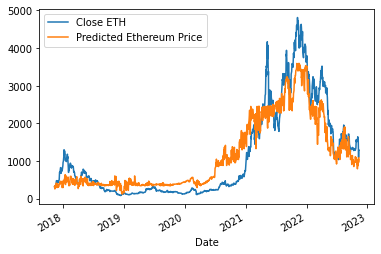

In [ ]:
df_comparison_eth[["Close ETH", "Predicted Ethereum Price"]].plot(
    kind="line",
)

## All Together

The 3 countries whose GDP appears to affect the price of the NASDAQ the most are the US, China, and Canada.

According to The International Monetary Fund (https://www.imf.org/en/Publications/WEO/weo-database/2022/October/weo-report?c=512,914,612,171,614,311,213,911,314,193,122,912,313,419,513,316,913,124,339,638,514,218,963,616,223,516,918,748,618,624,522,622,156,626,628,228,924,233,632,636,634,238,662,960,423,935,128,611,321,243,248,469,253,642,643,939,734,644,819,172,132,646,648,915,134,652,174,328,258,656,654,336,263,268,532,944,176,534,536,429,433,178,436,136,343,158,439,916,664,826,542,967,443,917,544,941,446,666,668,672,946,137,546,674,676,548,556,678,181,867,682,684,273,868,921,948,943,686,688,518,728,836,558,138,196,278,692,694,962,142,449,564,565,283,853,288,293,566,964,182,359,453,968,922,714,862,135,716,456,722,942,718,724,576,936,961,813,726,199,733,184,524,361,362,364,732,366,144,146,463,528,923,738,578,537,742,866,369,744,186,925,869,746,926,466,112,111,298,927,846,299,582,487,474,754,698,&s=PPPGDP,&sy=2020&ey=2027&ssm=0&scsm=1&scc=0&ssd=1&ssc=0&sic=0&sort=country&ds=.&br=1) these three countries are predicted to have the following GDPs in 2023:

Canada: \$2,353.876 billion  
China: \$32,529.230 billion  
US: \$26,185.210 billion  

In [ ]:
X_test = pd.DataFrame(index=["2023"], columns=["United States", "China", "Canada"])
X_test["United States"]["2023"] = 2.618521e+13
X_test["China"]["2023"] = 3.252923e+13
X_test["Canada"]["2023"] = 2.353876e+12
X_test.index = pd.to_datetime(X_test.index).year

In [ ]:
nasdaq_2023 = pd.DataFrame(columns=["Close NASDAQ"])
nasdaq_2023["Close NASDAQ"] = nasdaq_model.predict(X_test)
ethereum_model.predict(nasdaq_2023)[0]

3814.968640114648